<a href="https://colab.research.google.com/github/flex-akin/Hamoye_capstone_project_smote/blob/main/NASNetLarge_0_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/hassan-ademola/Hamoye_capstone_project_smote/blob/main/Deep%20learning/efficientnetb7_0.998/efficientnetb7_0.998.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [5]:
# necessary imports
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np

# for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
# define file paths
! git clone https://github.com/hassan-ademola/Hamoye_capstone_project_smote.git
train_path = 'Hamoye_capstone_project_smote/Data/train/'
val_path = 'Hamoye_capstone_project_smote/Data/val/'
test_path = 'Hamoye_capstone_project_smote/Data/test/'

Cloning into 'Hamoye_capstone_project_smote'...
remote: Enumerating objects: 10828, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 10828 (delta 19), reused 41 (delta 8), pack-reused 10768
Receiving objects: 100% (10828/10828), 360.62 MiB | 36.49 MiB/s, done.
Resolving deltas: 100% (24/24), done.
Checking out files: 100% (10810/10810), done.


In [28]:
# generate train and test sets from directories
train_ds = image_dataset_from_directory(train_path,label_mode='categorical',
                                        image_size=(331, 331))
val_ds = image_dataset_from_directory(val_path,label_mode='categorical',
                                      image_size=(331, 331))
test_ds = image_dataset_from_directory(test_path,label_mode='categorical',
                                       shuffle=False,image_size=(331, 331))

Found 7556 files belonging to 4 classes.
Found 2160 files belonging to 4 classes.
Found 1084 files belonging to 4 classes.


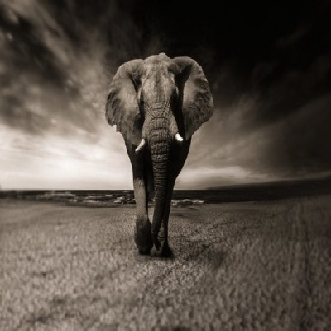

In [8]:
# load a sample image
from tensorflow.keras.preprocessing import image

img_path = train_path+'Elephant/Elephant_300.jpg'
img = image.load_img(img_path, target_size=(331, 331))
img

In [9]:
# make prediction with a pretrained model
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import decode_predictions

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

base_model = NASNetLarge(weights='imagenet')
pred = base_model.predict(x)
print('Predicted:', decode_predictions(pred))

49152/35363 [=========================================] - 0s 0us/step
Predicted: [[('n03223299', 'doormat', 0.03254556), ('n02999410', 'chain', 0.02512045), ('n03124043', 'cowboy_boot', 0.021641148), ('n04328186', 'stopwatch', 0.021178853), ('n04067472', 'reel', 0.02016974)]]


In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = NASNetLarge(weights='imagenet', include_top=False,
                            input_shape=(331,331,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

343621632/343610240 [==============================] - 3s 0us/step


In [12]:
# create callback to use during training
checkpoint = tf.keras.callbacks.ModelCheckpoint('Nasnet_weights.h5',save_best_only=True,
                                                    save_weights_only=True)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# train the model on the new data for a few epochs
history = model.fit(train_ds,epochs=5,validation_data=val_ds,
                    callbacks=[checkpoint])

Epoch 1/5
237/237 [==============================] - 680s 3s/step - loss: 1.1685 - accuracy: 0.5001 - val_loss: 1.0548 - val_accuracy: 0.5838
Epoch 2/5
237/237 [==============================] - 644s 3s/step - loss: 1.0126 - accuracy: 0.5940 - val_loss: 0.9602 - val_accuracy: 0.6356
Epoch 3/5
237/237 [==============================] - 642s 3s/step - loss: 0.9539 - accuracy: 0.6190 - val_loss: 0.9954 - val_accuracy: 0.5907
Epoch 4/5
237/237 [==============================] - 642s 3s/step - loss: 0.9104 - accuracy: 0.6415 - val_loss: 0.9955 - val_accuracy: 0.5833
Epoch 5/5
237/237 [==============================] - 644s 3s/step - loss: 0.8712 - accuracy: 0.6595 - val_loss: 0.8660 - val_accuracy: 0.6611


In [13]:
# save results
results = history.history

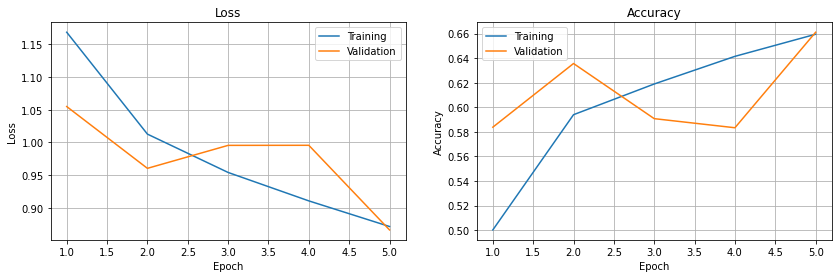

In [14]:
# plot results
import matplotlib.pyplot as plt
n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])
plt.grid(True)
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model.load_weights('Nasnet_weights.h5')

In [16]:
predictions = model.evaluate(test_ds)

34/34 [==============================] - 76s 2s/step - loss: 0.9129 - accuracy: 0.6292


In [17]:
# make predictions on the unseen data
predictions = model.predict(test_ds)
predictions

array([[0.54249215, 0.26507345, 0.10775355, 0.08468086],
       [0.15265591, 0.26739612, 0.504325  , 0.07562302],
       [0.48266286, 0.17198928, 0.19200353, 0.1533443 ],
       ...,
       [0.02919996, 0.0202366 , 0.09593617, 0.8546273 ],
       [0.03873136, 0.07220921, 0.05896334, 0.8300961 ],
       [0.01051828, 0.00857752, 0.03194446, 0.94895977]], dtype=float32)

In [18]:
# save the index of the highest probability
predictions = predictions.argmax(axis=1)
predictions

array([0, 2, 0, ..., 3, 3, 3])

In [19]:
# get the actual values
test_images = list(test_ds.unbatch().as_numpy_iterator())
y_true = np.array([i[1] for i in test_images])
y_true = y_true.argmax(axis=1)
y_true

array([0, 0, 0, ..., 3, 3, 3])

In [20]:
# calculate f1_score
from sklearn.metrics import f1_score
f1_score(y_true,predictions,average='macro')

0.6234601697171587

In [21]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,predictions)

array([[166,  41,  50,  14],
       [ 45,  99, 117,  10],
       [ 18,  17, 218,  18],
       [ 15,  13,  44, 199]])

The model misclassified **rhinos**. Let's see

In [22]:
import pandas as pd
comparison = pd.DataFrame({'actual':y_true,'predicted':predictions,
                           'same':y_true==predictions})
comparison.replace({0:'Buffalo',1:'Elephant',2:'Rhino',3:'Zebra'},inplace=True)
comparison[comparison.same==False]

,actual,predicted,same
1,Buffalo,Rhino,False
12,Buffalo,Rhino,False
17,Buffalo,Rhino,False
18,Buffalo,Rhino,False
21,Buffalo,Rhino,False
...,...,...,...
1050,Zebra,Rhino,False
1052,Zebra,Rhino,False
1065,Zebra,Rhino,False
1072,Zebra,Rhino,False


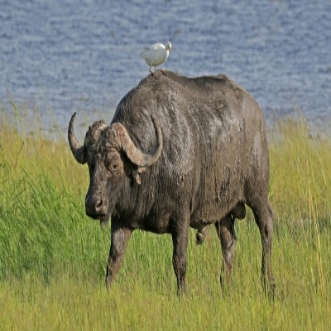

In [24]:
image.array_to_img(test_images[12][0])

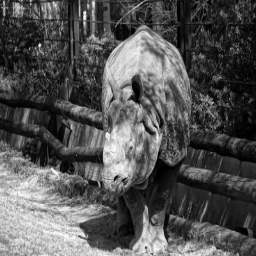

In [ ]:
image.array_to_img(test_images[633][0])

In [ ]:
# uncomment the below to save the model
'''import pickle
pickle.dump(model, open('efficientnetb7.pkl', 'wb'))'''

In [30]:
#Retrain attempt

base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.Accuracy()],
)

epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 165, 165, 96  2592        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 165, 165, 96  384         ['stem_conv1[0][0]']             
                                )                                                             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


ResourceExhaustedError: ignored

In [33]:
pip install pyyaml h5py


In [34]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [36]:
# uncomment the below to save the model
import pickle
pickle.dump(model, open('Nasnet.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://ea4d5cd0-98a0-4011-8474-11de15359407/assets
